In [2]:
!pip install komm
!pip install scikit-commpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.8 MB/s 
  Created wheel for komm: filename=komm-0.7.1-py3-none-any.whl size=56608 sha256=79454ff12c0f76e8b5fe561145b508853722e9d50bcf6e68a55e031433d2f6ce
  Stored in directory: /root/.cache/pip/wheels/67/d6/14/a8e4b0235b3dc3c8a28c4e2059b66ad5b8c262df15df54f843
Successfully built komm
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 638 kB/s 
  Created wheel for scikit-commpy: filename=scikit_commpy-0.7.0-py3-none-any.whl size=58556 sha256=a742089d0f18ef7fec56180d863e35cdf473a33219bd4d6b3d5f19ab13bda933
  Stored in directory: /root/.cache/pip/wheels/52/2a/a2/2daff6a2d5e3b96d70fb03e5b0699ce70c98cb4c00c8107c38
Successfully built scikit-commpy


In [3]:
import numpy as np
from numpy import log2,sqrt,sin,pi,exp
from scipy.special import erfc
from scipy.integrate import quad
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal

def ber_awgn(EbN0dBs,mod_type=None,M=0,coherence=None):
    """
    Theoretical Symbol Error Rates for various modulations over AWGN
    Parameters:
        EbN0dBs : list of SNR per bit values in dB scale
        mod_type : 'PSK','QAM','PAM','FSK'
        M : Modulation level for the chosen modulation.
            For PSK,PAM,FSK M can be any power of 2.
            For QAM M must be even power of 2 (square QAM only)
        coherence : 'coherent' for coherent FSK detection
                    'noncoherent' for noncoherent FSK detection
                This parameter is only applicable for FSK modulation
    Returns:
        SERs = Symbol Error Rates
    """
    if mod_type==None:
        raise ValueError('Invalid value for mod_type')
    if (M<2) or ((M & (M -1))!=0): #if M not a power of 2
        raise ValueError('M should be a power of 2')
    
    func_dict = {'BPSK': psk_awgn,'QPSK': psk_awgn,'16QAM':qam_awgn,'64QAM':qam_awgn}
    
    gamma_s = (10**(EbN0dBs/10))
    if mod_type.lower()=='fsk': #call appropriate function
        return func_dict[mod_type.lower()](M,gamma_s,coherence) 
    else:
        return func_dict[mod_type](M,gamma_s) #call appropriate function

def psk_awgn(M,gamma_s):
    #gamma_b = gamma_s/log2(M)
    if (M==2):
        BERs = 0.5*erfc(sqrt(gamma_s))
        #0.5*erfc(np.sqrt(10**(EbN0dBs/10)))
    elif M==4:
        BERs = 0.5*erfc(sqrt(gamma_s))
        # SERs = 2*Q-Q**2
    else:
        BERs = erfc(sqrt(gamma_s)*sin(pi/M))
    return BERs

def qam_awgn(M,gamma_s):
    if (M==1) or (np.mod(np.log2(M),2)!=0): # M not a even power of 2
        raise ValueError('Only square MQAM supported. M must be even power of 2')
    #SERs = 1-(1-(1-1/sqrt(M))*erfc(sqrt(3/2*gamma_s/(M-1))))**2
    # BERs=(4/log2(M))*erfc(sqrt((3*gamma_s*log2(M))/(M-1)))
    elif(M==16):
      BERs = 3/4*erfc(sqrt(4/5*gamma_s))+ 1/2*erfc(3*sqrt(4/5*gamma_s))-1/4*erfc(5*sqrt(4/5*gamma_s));
    else:
      BERs = 7/12*erfc(sqrt(2/7*gamma_s))+ 1/2*erfc(3*sqrt(2/7*gamma_s))-1/12*erfc(5*sqrt(2/7*gamma_s))+ 1/12*erfc(9*sqrt(2/7*gamma_s))- 1/12*erfc(13*sqrt(2/7*gamma_s));

    return BERs


def awgn(s,SNRdB,L=1):
    """
    AWGN channel
    
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal
    's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power
    spectral density N0 of noise added
    
    Parameters:
        s : input/transmitted signal vector
        SNRdB : desired signal to noise ratio (expressed in dB)
            for the received signal
        L : oversampling factor (applicable for waveform simulation)
            default L = 1.
    Returns:
        r : received signal vector (r=s+n)
    """
    gamma = 10**(SNRdB/10) #SNR to linear scale
    
    if s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
        
    N0=P/gamma # Find the noise spectral density    
    if isrealobj(s):# check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # received signal    
    return r


In [4]:
import numpy as np
import abc

class Equalizer():
    # Base class: Equalizer (Abstract base class)
    # Attribute definitions:
    #    self.N: length of the equalizer
    #    self.w : equalizer weights
    #    self.delay : optimized equalizer delay
    def __init__(self,N): # constructor for N tap FIR equalizer
        self.N = N
        self.w = np.zeros(N)
        self.opt_delay = 0
        
    @abc.abstractmethod
    def design(self): #Abstract method
        "Design the equalizer for the given impulse response and SNR"
    
    def convMatrix(self,h,p):
        """
        Construct the convolution matrix of size (N+p-1)x p from the
        input matrix h of size N. (see chapter 1)
        Parameters:
            h : numpy vector of length L
            p : scalar value
        Returns:
            H : convolution matrix of size (L+p-1)xp
        """
        col=np.hstack((h,np.zeros(p-1)))
        row=np.hstack((h[0],np.zeros(p-1)))
        
        from scipy.linalg import toeplitz
        H=toeplitz(col,row)
        return H
        
    def equalize(self,inputSamples):
        """
        Equalize the given input samples and produces the output
        Parameters:
            inputSamples : signal to be equalized
        Returns:
            equalizedSamples: equalized output samples
        """
        #convolve input with equalizer tap weights
        equalizedSamples = np.convolve(inputSamples,self.w)
        return equalizedSamples   
class zeroForcing(Equalizer): #Class zero-forcing equalizer
    def design(self,h,delay=None): #override method in Equalizer abstract class
        """
        Design a zero forcing equalizer for given channel impulse response (CIR).
        If the tap delay is not given, a delay optimized equalizer is designed
        Parameters:
            h : channel impulse response
            delay: desired equalizer delay (optional)
        Returns: MSE: Mean Squared Error for the designed equalizer
        """
        L = len(h)
        H = self.convMatrix(h,self.N) #(L+N-1)xN matrix - see Chapter 1
        # compute optimum delay based on MSE
        Hp = np.linalg.pinv(H) #Moore-Penrose Pseudo inverse
        #get index of maximum value using argmax, @ for matrix multiply
        opt_delay = np.argmax(np.diag(H @ Hp))
        self.opt_delay = opt_delay #optimized delay
        
        if delay==None:
            delay=opt_delay
        elif delay >=(L+self.N-1):
            raise ValueError('Given delay is too large delay (should be < L+N-1')
        
        k0 = delay
        d=np.zeros(self.N+L-1);d[k0]=1 #optimized position of equalizer delay
        self.w=Hp @ d # Least Squares solution, @ for matrix multiply
        MSE=(1-d.T @ H @ Hp @ d) #MSE and err are equivalent,@ for matrix multiply
        return MSE

class MMSEEQ(Equalizer): #Class MMSE Equalizer
    def design(self,h,snr,delay=None): #override method in Equalizer abstract class
        """
        Design a MMSE equalizer for given channel impulse response (CIR) and
        signal to noise ratio (SNR). If the tap delay is not given, a delay
        optimized equalizer is designed
        Parameters:
            h : channel impulse response
            snr: input signal to noise ratio in dB scale
            delay: desired equalizer delay (optional)
        Returns: MSE: Mean Squared Error for the designed equalizer
        """
        L = len(h)
        H=self.convMatrix(h,self.N) #(L+N-1)xN matrix - see Chapter 1
        gamma = 10**(-snr/10) # inverse of SNR
        # compute optimum delay
        opt_delay = np.argmax(np.diag(H @ np.linalg.inv(H.T @ H+gamma * np.eye(self.N))@ H.T)) # @ for matrix multiply
        self.opt_delay = opt_delay #optimized delay
        
        if delay==None:
            delay=opt_delay
        if delay >=(L+self.N-1):
            raise ValueError('Given delay is too large delay (should be < L+N-1')
        
        k0 = delay
        d=np.zeros(self.N+L-1)
        d[k0]=1 # optimized position of equalizer delay
        # Least Squares solution, @ for matrix multiply
        self.w=np.linalg.inv(H.T @ H+ gamma * np.eye(self.N))@ H.T @ d
        # assume var(a)=1, @ for matrix multiply
        MSE=(1-d.T @ H @ np.linalg.inv(H.T @ H+gamma * np.eye(self.N)) @ H.T @ d)
        return MSE
    
class LMSEQ(Equalizer): #Class LMS adaptive equalizer
    def design(self,mu,r,a):
        """
        Design an adaptive FIR filter using LMS update equations (Training Mode)
        Parameters:
            N : desired length of the filter
            mu : step size for the LMS update
            r : received/input sequence
            a: reference sequence
        """
        N =self.N
        w = np.zeros(N)
        for k in range(N, len(r)):
            r_vector = r[k:k-N:-1]
            e = a[k] - w @ r_vector.T # @ denotes matrix multiplication
            w = w + mu * e * r_vector # @ denotes matrix multiplication
        self.w = w #set the final filter coefficients  

In [12]:
import numpy as np
from scipy.fftpack import fft, ifft
from komm import PSKModulation
import commpy.channelcoding.convcode as cc
from komm import QAModulation
from komm import AWGNChannel

def generateRandBits(length):
  bits = np.random.binomial(n=1, p=0.5, size=length)
  return bits

def encodeBits(bits,trellis):
  return cc.conv_encode(bits, trellis)

def modulatationSelect(type):
  if(type=='16QAM'):
    mod = QAModulation(16)
  elif(type=='64QAM'):
    mod = QAModulation(64)
  elif(type=='BPSK'):
    mod = PSKModulation(2)
  elif(type=='QPSK'):
    mod = PSKModulation(4)
  else:
    print("Not a modulation type.")
  return mod

def modulation(encodedBits,mod):
  return mod.modulate(encodedBits)

# inverse fast fourier transformation 
def IFFT(moddedBits):
  return ifft(moddedBits)
'''
addGI: add a cyclic prefix of 1/4 as a guard interval. This type of GI provides two main functions:
1) The cyclic prefix provides a guard interval to eliminate intersymbol interference from the previous symbol.
   -InterSymbol Interference (ISI) is a kind of distortion that occurs when one or more symbols (pulses in digital baseband transmission) 
    interfere with subsequent signals. This can cause noise in the signal which can cause the output to be less than ideal.
   -ISI occurs when there is multipath propagation and/or nonlinear frequency in the channels.  These causes can be reduced 
    which can help eliminate ISI from the system to achieve an ideal output.
2) It repeats the end of the symbol so the linear convolution of a frequency-selective multipath channel can 
be modeled as circular convolution, which in turn may transform to the frequency domain via a discrete Fourier transform. 
This approach accommodates simple frequency domain processing, such as channel estimation and equalization. 
'''
def addGI(ifftData,lengthOfBits):
    cp = ifftData[-lengthOfBits//4:]
    return np.hstack([cp, ifftData]) 

def addAWGN(ifftBits,snr):
  return awgn(ifftBits,snr,L=1)

def removeGI(signal,lengthOfBits):
    return signal[lengthOfBits//4:(lengthOfBits//4+lengthOfBits)]

def FFT(awgnBits):
  return fft(awgnBits) 

def demodulation(fftBits,mod):
  return mod.demodulate(fftBits)

def decodeBits(demoddedBits,trellis):
  return cc.viterbi_decode(demoddedBits.astype(float), trellis)

def run(bitLen,modType,snr,trellis):
  totalBitErrors=0
  bits=generateRandBits(bitLen)
  #print(bits)
  #en=encodeBits(bits,trellis)
  en=bits
  # adds padded 0s to encoded bits to ensure that each subcarrier has
  # the same amount of bits with respect to its' scheme.
  if(modType=="QPSK"):
    while(len(en)%2 != 0):
      en=np.append(en,0)
  if(modType=="16QAM"):
    while(len(en)%4 != 0):
      en=np.append(en,0)
  if(modType=="64QAM"):
    while(len(en)%6 != 0):
      en=np.append(en,0)
  mod=modulatationSelect(modType)
  modded=modulation(en,mod)
  # print(modded)
  #ifft=IFFT(modded)
  #addGI(ifft,len(bits))
  # print(ifft)
  snr = snr + (10 * np.log10(len(bits)/len(modded)))
  awgn=addAWGN(modded,snr)
  #removeGI(awgn,len(bits))
  # print(awgn)
  #fft=FFT(awgn)
  # print(fft)
  # eq=Equalizer(14)
  # equalized=eq.equalize(demod)
  demod=demodulation(awgn,mod)
  
  # print("demod",demod)
  #decode=decodeBits(demod,trellis)
  demod=demod[:len(bits)]
  # print(len(decode))
  # for i in range(len(bits)):
  #   if bits[i]!=demod[i]:
  #     totalBitErrors+=1

  return np.sum(bits!=demod)

def simulator(numOfSims,bitLen,modType,snrs,trellis):
  modTypeToM={'BPSK':2,'QPSK':4,'16QAM':16,'64QAM':64}
  modTypeToBitPerSym={'BPSK':1,'QPSK':2,'16QAM':4,'64QAM':6}
  BERs=[]
  theory=[]
  for snr in snrs:
    allBitErrors=0
    for i in range(numOfSims):
      errors=run(bitLen,modType,snr,trellis)
      allBitErrors+=errors
    BERs=np.append(BERs,allBitErrors/(bitLen*numOfSims))
    theory = np.append(theory,(ber_awgn(snr,modType,modTypeToM[modType]))) #theory SER
  return BERs,theory
  

KeyboardInterrupt: ignored

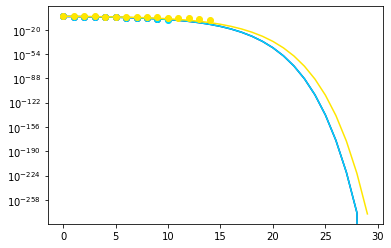

In [14]:
import numpy as np# for numerical computing
import matplotlib.pyplot as plt# for plotting functions
from matplotlib import cm # colormap for color palette
from scipy.special import erfc
# Number of delay elements in the convolutional encoder
memory = np.array(1, ndmin=1)
# Generator matrix
g_matrix = np.array((0o5, 0o7), ndmin=2)
# Create trellis data structure
trellis = cc.Trellis(memory, g_matrix)
modTypes=['BPSK','QPSK','16QAM','64QAM']
colors = plt.cm.jet(np.linspace(0,1,len(modTypes))) # colormap
fig, ax = plt.subplots(nrows=1,ncols = 1)
snrs=np.arange(start=0,stop = 30, step = 1)
for i,modType in enumerate(modTypes):
  BERs,theory=simulator(1000,1000,modType,snrs,trellis)
  ax.semilogy(snrs,BERs,color =colors[i],marker='o',linestyle='',label='Sim'+'-'+modType)
  ax.semilogy(snrs,theory,color = colors[i],linestyle='-',label='Theory'+'-'+modType)
ax.set_xlabel('Eb/N0(dB)');ax.set_ylabel('BERs ($P_s$)')
ax.set_title('Probability of Bit Error for all Modulations over AWGN')
ax.set_ylim([10**-11, 10**0])
ax.legend();fig.show()
fig.set_size_inches(8, 8)